Epoch 0: Train MCC=0.8492, Val MCC=0.8854
Epoch 10: Train MCC=0.8743, Val MCC=0.9084
Epoch 20: Train MCC=0.8745, Val MCC=0.9051
Epoch 30: Train MCC=0.8755, Val MCC=0.9171
Epoch 40: Train MCC=0.8804, Val MCC=0.9012
Epoch 50: Train MCC=0.8811, Val MCC=0.9091
Epoch 60: Train MCC=0.8818, Val MCC=0.9012
Epoch 70: Train MCC=0.8820, Val MCC=0.9012
Epoch 80: Train MCC=0.8833, Val MCC=0.9051
Epoch 90: Train MCC=0.8816, Val MCC=0.8946

Training finished. Loaded weights with best Val MCC: 0.9244


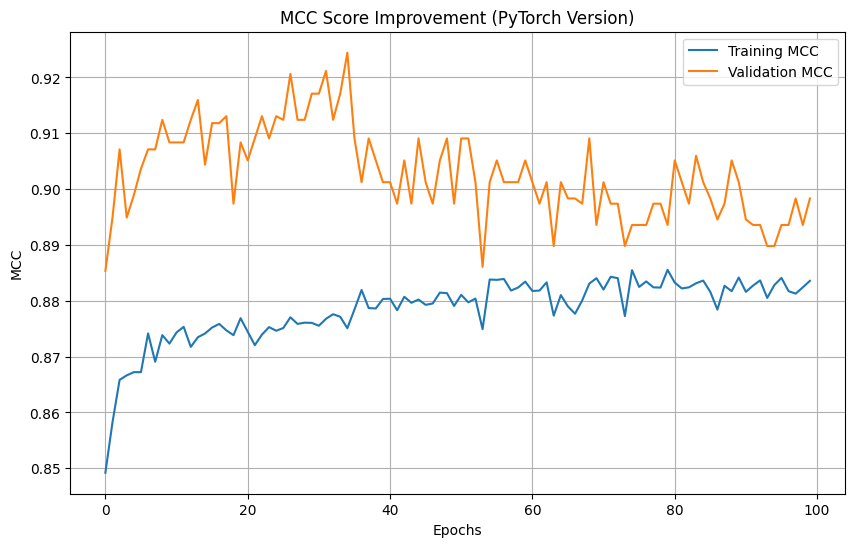

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import matthews_corrcoef
import random

# set random seeds
seed_value = 4
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# --- 1. Load and Preprocess Data ---
# Load data (assuming they are in the same directory)
train_raw = pd.read_csv('train.dat', header=None).values
test_raw = pd.read_csv('test.dat', header=None).values

X_train_full = train_raw[:, 1:].astype(np.float32)
y_train_full = train_raw[:, 0].astype(np.float32).reshape(-1, 1)
X_test_full = test_raw.astype(np.float32)

# Z-score Normalization (using training stats only)
mean = X_train_full.mean(axis=0)
std = X_train_full.std(axis=0)
X_train_full = (X_train_full - mean) / std
X_test_full = (X_test_full - mean) / std

# Split for Validation (80/20)
indices = np.random.permutation(len(X_train_full))
split = int(0.9 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
X_val, y_val = X_train_full[val_idx], y_train_full[val_idx]

# Calculate Class Weight for Imbalance [cite: 113]
num_pos = np.sum(y_train == 1)
num_neg = np.sum(y_train == 0)
pos_weight_val = torch.tensor([num_neg / num_pos])

# Prepare DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# --- 2. Define the Neural Network ---
class PulsarNN(nn.Module):
    def __init__(self):
        super(PulsarNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Dropout(p = 0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

# --- 3. Training Setup ---
model = PulsarNN()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
criterion = nn.BCELoss(reduction='none') # We'll apply weights manually

epochs = 100
train_mccs = []
val_mccs = []
best_val_mcc = -1
best_model_state = None

# --- 4. Training Loop ---
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_X)
        
        # Apply weighting to handle class imbalance [cite: 113]
        loss_raw = criterion(preds, batch_y)
        weights = torch.ones_like(batch_y)
        weights[batch_y == 1] = pos_weight_val
        loss = (loss_raw * weights).mean()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # Evaluation for Plotting
    model.eval()
    with torch.no_grad():
        # Train MCC
        t_preds = model(torch.from_numpy(X_train)).numpy()
        t_mcc = matthews_corrcoef(y_train, (t_preds > 0.8).astype(int))
        train_mccs.append(t_mcc)
        
        # Val MCC
        v_preds = model(torch.from_numpy(X_val)).numpy()
        v_mcc = matthews_corrcoef(y_val, (v_preds > 0.8).astype(int))
        val_mccs.append(v_mcc)
        
        # Keep the best weights
        if v_mcc > best_val_mcc:
            best_val_mcc = v_mcc
            best_model_state = model.state_dict().copy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train MCC={t_mcc:.4f}, Val MCC={v_mcc:.4f}")

print(f"\nTraining finished. Loaded weights with best Val MCC: {best_val_mcc:.4f}")
# --- 5. Plotting MCC ---
plt.figure(figsize=(10, 6))
plt.plot(train_mccs, label='Training MCC')
plt.plot(val_mccs, label='Validation MCC')
plt.title('MCC Score Improvement (PyTorch Version)')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.legend()
plt.grid(True)
plt.show()

# # --- 6. Generate Test Predictions ---
# # Load best weights
# model.load_state_dict(best_model_state)
# model.eval()
# test_probs = model(torch.from_numpy(X_test_full)).detach().numpy()
# test_labels = (test_probs >= optimal_threshold).astype(int)
# np.savetxt('test.txt', test_labels, fmt='%d')
# print("Predictions saved to test.txt")